In [3]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import sklearn
from sklearn import ensemble
from sklearn import datasets
from sklearn import model_selection
import statsmodels.api as sm
import statsmodels.formula.api as smf
#The capstone project is about Beijing pm2.5 level, which focus on its change and potential affecting factors
#My dataset comes from UCI Machine Learning Repository, and it can be accessed publicly
#The capstone project will include the following contents:
#Extract data from website
#CLean raw data, including renaming columns, adding columns and removing null values
#Visualize pm2.5 level change regarding to month and year
#Construct linear regression, random forest regressor and random forest classifier model to make predictive analysis and compare the accuracy

In [36]:
#Data extraction
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv')
df.head()
#rename columns
mydata = df.rename(columns = {'pm2.5':'pm','DEWP': 'dew_point', 'TEMP': 'temperature', 'PRES': 'pressure', 'cbwd':'wind_direction', 'Iws':'wind_speed','Is':'snow_hour','Ir':'rain_hour'})
#remove null values
mydata.dropna(how = 'any', inplace = True)
#set index start from 0
mydata.index = range(len(mydata))
mydata.head()

,No,year,month,day,hour,pm,dew_point,temperature,pressure,wind_direction,wind_speed,snow_hour,rain_hour
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


/Users/lanting/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'pm2.5 change by month')

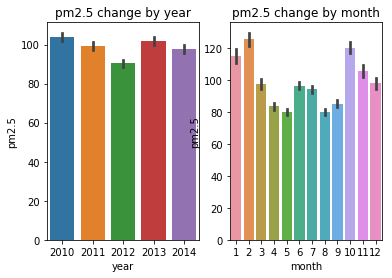

In [21]:
#data visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
sns.barplot(x = 'year', y = 'pm', data = mydata)
plt.title('pm2.5 change by year')
plt.subplot(1,2,2)
sns.barplot(x = 'month', y = 'pm', data = mydata)
plt.title('pm2.5 change by month')

In [59]:
#predictive analysis
#split dataset into train and test sets at the rate of 7:3
X = mydata.iloc[:, 6:12]
y = mydata.iloc[:,5]
y,X = dmatrices('pm ~ dew_point+temperature+pressure+wind_direction+wind_speed+snow_hour+rain_hour', data=mydata)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
#linear regression
model1 = smf.OLS(y_train, X_train)
result = model1.fit()
yhat1 = result.predict(X_test)
print(result.summary())
#calculate the mean square error which represent the accuracy
mse = np.mean((np.array(yhat1)-np.array(y_test))** 2)
mse
#In this case, linear regression is not a good model because R-square is only 25.9 which means the change of potential
#affecting factors can not translate the change of pm2.5 well
#However,the p values of the test are all less than 0.05,which means the influences are significant 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     1136.
Date:                Mon, 29 Oct 2018   Prob (F-statistic):               0.00
Time:                        23:11:38   Log-Likelihood:            -1.6913e+05
No. Observations:               29229   AIC:                         3.383e+05
Df Residuals:                   29219   BIC:                         3.384e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
var_0       1766.9735     85.816     20.590      0.0

10863.209519057764

/Users/lanting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


13608.766230736266


/Users/lanting/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


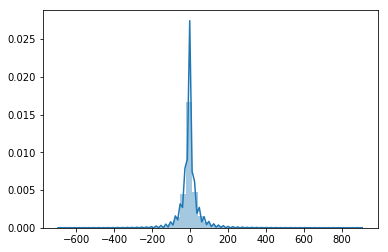

In [71]:
#Random Forest Regressor
model2 = sklearn.ensemble.RandomForestRegressor()
model2.fit(X_train, y_train)
yhat2 = model2.predict(X_test)
#calculate mean square error
mse2 = np.mean((np.array(yhat2)-np.array(y_test))**2)
print(mse2)
#In this case, random forest regressor has higher mean square error which is 13556.24 than that of linear regression which is 10863.21
#Linear regression is more accurate in this case
y,X = dmatrices('pm ~ dew_point+temperature+pressure+wind_direction+wind_speed+snow_hour+rain_hour', data=mydata)
sns.distplot(y.ravel() - model2.predict(X))

In [79]:
#define a classified column in dataset, defining the air quality depending on pm2.5 level
def air_quality(c):
    if c['pm'] <= 50:
        return 'good'
    elif 50 <c['pm'] <= 100:
        return 'accptable'
    else:
        return 'bad'
mydata['air_quality'] = mydata.apply(air_quality, axis =1)
mydata.head()
#Use random forest classifier to make prediction again
model3 = sklearn.ensemble.RandomForestClassifier()
model3.fit(X_train,y_train)
yhat3 = model3.predict(X_test)
print(sklearn.metrics.classification_report(y_test, yhat3))
#use accuracy score to double check the quality of the model
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, yhat3, normalize=True))
#By looking at the accuracy score, along with the precision and recall result, we can see that
#The fraction of correctly classified sample is only 2.17%

/Users/lanting/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         1
        1.0       0.50      1.00      0.67         1
        2.0       0.00      0.00      0.00         3
        3.0       0.04      0.07      0.05        14
        4.0       0.06      0.08      0.07        26
        5.0       0.05      0.05      0.05        39
        6.0       0.04      0.10      0.06        59
        7.0       0.07      0.09      0.08       104
        8.0       0.04      0.07      0.05       112
        9.0       0.08      0.13      0.10       148
       10.0       0.07      0.08      0.07       184
       11.0       0.04      0.07      0.05       175
       12.0       0.10      0.12      0.11       184
       13.0       0.03      0.06      0.04       163
       14.0       0.05      0.06      0.05       153
       15.0       0.03      0.03      0.03       160
       16.0       0.04      0.04      0.04       191
       17.0       0.06      0.08      0.07   

/Users/lanting/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lanting/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
